In [54]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import pandas

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path


mypal = sns.color_palette('Set2')
emp_color = mypal[0]
pred_color = mypal[1]
print ("PyTorch version: " + torch.__version__)


PyTorch version: 1.8.0


In [55]:
from torch.utils.data import Dataset, DataLoader, Sampler
# without transformation at the batch step
class SimpleDataset(Dataset):
    def __init__(self, x, y, e):
        self.data = x
        self.targets = y
        self.label = e
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        return img, target, label
        
        
    def __len__(self):
        return len(self.data)
    
#     def get_mean_std(self):            
#         mean = np.mean(self.data[:,self.covlist], axis = 0)
#         std = np.std(self.data[:,self.covlist], axis = 0)
# #         print(std)
#         # set covariates with std =0 has std = mean
#         std[std==0] = mean[std==0]+1e-3

#         return mean, std

In [56]:
class SimpleDataset_trans(Dataset):
    def __init__(self, x, y, e, transform=False, covlist = None, mean=0, std = 1):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform
        self.covlist = covlist
        if not self.covlist:
            self.covlist = np.arange(self.data.shape[1])
        
        if self.transform:
            self.mean, self.std = mean, std
            
    def __getitem__(self, index):
        img = self.data[index]
        target = self.targets[index]
        label = self.label[index]
        
        if self.transform:
            return (img[self.covlist]-self.mean)/self.std, target, label
        else:
            return img, target, label
        
        

    def __len__(self):
        return len(self.data)

## Cox-gompertz linear setting

Load framingham dataset

In [57]:
from data.simulation import simulation_cox_weibull_all

file_path = '/data/zidi/framingham/'
result_path_root = '/data/zidi/ACSurv/results/toy'
# file_path = '/Users/ZidiXiu/Dropbox/Research/framingham/data/'
# result_path_root = "/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results"+'/toy'

cut_bound = 6
df= simulation_cox_weibull_all(n=20000, censor_bound=0)

# change to non-ohe 
cat0_level = df['ohe'][0]
cat1_level = df['ohe'][1]

# cat0 = 0*df['x'][:,2] + 1*df['x'][:,3]+ 2*df['x'][:,4]+ 3*df['x'][:,5]
cat0 = np.sum(np.array([level*df['x'][:, 3+level] for level in range(cat0_level)]),0).reshape(-1,1)
cat1 = np.sum(np.array([level*df['x'][:, 3+cat0_level+level] for level in range(cat1_level)]),0).reshape(-1,1)


df['x'] = np.concatenate((df['x'][:,df['cts_idx']], cat0, cat1), axis=1)
nsamples, ncov= df['x'].shape

cov_list = np.array(['AGE','RANDON', 'INTA', 'cat0','cat1'])
cts_idx = df['cts_idx']
cts_var = cov_list[cts_idx]
cat_idx = np.setdiff1d(np.arange(ncov), cts_idx)
cat_var = cov_list[cat_idx]

np.mean(df['e'])

1.0

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(<AxesSubplot:ylabel='count'>, array([3, 4]))

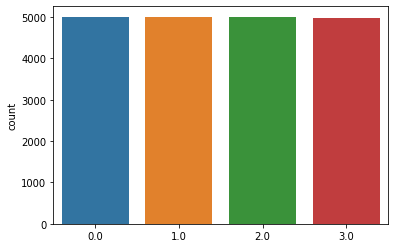

In [58]:
sns.countplot(df['x'][:,-2]), cat_idx

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

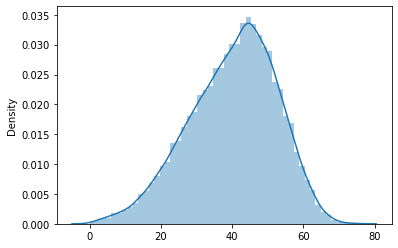

In [59]:
sns.distplot(df['T'])

In [60]:
from data.utils import *
nsamples, ncov= df['x'].shape
np.random.seed(123)
all_idx = np.arange(nsamples)
all_idx = np.random.permutation(all_idx)
train_idx = all_idx[:int(2*nsamples/3)]
valid_idx = all_idx[int(2*nsamples/3):]

train = formatted_data(df['x'], df['t'], df['e'], train_idx)
valid = formatted_data(df['x'], df['t'], df['e'], valid_idx)

del df

observed fold:1.0
observed fold:1.0


### Embedding the covariates into $\mathbb{R}^m$
- for each continuous variable, first find $m$ landmarkers, then interpolate values in between
- for each categorical variable, find the matched embedding vector with $m$ dimensions

Define landmarkers for each continuous variable### Embedding the covariates into $\mathbb{R}^m$

In [61]:
def landmarks_init(dataset, m, cts_var=None, cts_idx = None, device='cpu'):
    '''
    continuous_idx: 
    
    '''
    if type(cts_var) == type(None):
        cts_idx = np.arange(dataset['x'].shape[1])
        cts_var = cts_idx
    
    # creat landmarks as traditional dictionary
    x_landmarks = {}

    [x_landmarks.update({var: torch.tensor(np.percentile(dataset['x'][:,c_idx], np.linspace(0,100,m))).to(device).contiguous()}) for c_idx, var in zip(cts_idx, cts_var)]

    # save the initialized landmarks as a torch parameter dictionary
    x_emb_landmarks = nn.ParameterDict({})
    for var in cts_var:
        m = len(x_landmarks[var])
        x_emb_landmark = torch.eye(m)
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_landmark)})
        x_emb_landmarks.update(new_dict)
        
    return x_landmarks, x_emb_landmarks

# x_landmarks, x_emb_landmarks = landmarks_init(train, m, continuous_variables)
# x_landmarks, x_emb_landmarks

In [62]:
# x_landmarks, x_emb_landmarks = landmarks_init(train, 10, cts_var, cts_idx, device='cuda')
# x_landmarks, x_emb_landmarks

In [63]:
# x_landmarks.keys(), x_emb_landmarks.keys()

### Linear Interpolation for continuous variables

$x_b \le x < x_{b+1}$, $\text{emb}(x) = \text{emb}(x_b) + \frac{\text{emb}(x_{b+1}) - \text{emb}(x_b)}{x_{b+1}-x_b}(x-x_{b})$

In [64]:

# def linear_interpolation_np(x, x_landmarks):
#     # apply numpy package
#     m = len(x_landmarks)
#     x_emb_landmarks = np.eye(m)
#     # returns index
#     # a[i-1] < v <= a[i]
#     indx = np.searchsorted(x_landmarks, x)
#     # combine the first two indices, and the last two indices
#     # to include the unobserved minimum and maximum value
#     # combines [0,1], and [m-1, m]
#     indx = np.where(indx==0, 1, indx)
#     indx = np.where(indx==m, m-1, indx)

#     # linear interpolation
#     def helper(idx, x0):
#         return x_emb_landmarks[idx-1] + (x0-x_landmarks[idx-1])*(x_emb_landmarks[idx] - x_emb_landmarks[idx-1])/(x_landmarks[idx]-x_landmarks[idx-1])
    
#     out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(np.vstack(out))


def linear_interpolation_var(x, x_landmark, x_emb_landmark):
    # written for torch
    # returns index
    # a[i-1] < v <= a[i]
    indx = torch.searchsorted(x_landmark, x)
    # combine the first two indices, and the last two indices
    # to include the unobserved minimum and maximum value
    # combines [0,1], and [m-1, m]
    indx = torch.where(indx==0, 1, indx)
    indx = torch.where(indx==m, m-1, indx)

    # linear interpolation
    def helper(idx, x0):
        return x_emb_landmark[idx-1] + (x0-x_landmark[idx-1])*(x_emb_landmark[idx] - x_emb_landmark[idx-1])/(x_landmark[idx]-x_landmark[idx-1])
    
    out = [helper(idx,x0) for idx, x0 in zip(indx, x)]
#     print(torch.vstack(out))
    return torch.vstack(out)

In [65]:
def cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var=None, cts_idx=None):
    
#     m = len(x_landmarks[0])
    if type(cts_var) == type(None):
        cts_var = x_landmarks.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cts_idx, cts_var):
        m = len(x_landmarks[var])
        cur_emb = linear_interpolation_var(x[:,c_idx], x_landmarks[var], x_emb_landmarks[var])
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
#     return torch.cat(res, 1)

In [66]:
# cts_interpolation(torch.tensor(train['x'][:20]).float(), x_landmarks, x_emb_landmarks, cts_var, cts_idx, device)

In [67]:
    '''
    To handle missingness, indicating by a masking matrix
    1 for observed, 0 for censored
    
    If missing, no need to interpolation at this location
    '''

# def cts_interpolation_mask(x, x_landmarks, x_emb_landmarks, continuous_variables=None, device='cpu'):
#     '''
#     To handle missingness, indicating by a masking matrix
#     1 for observed, 0 for censored
    
#     To be completed
#     '''
#     m = len(x_landmarks[0])
#     if type(continuous_variables) == type(None):
#         continuous_variables = np.arange(len(x_landmarks))
#     # find values variable by variable
#     res = []
#     for var in continuous_variables:
#         cur_emb = linear_interpolation_var(x[:,var], x_landmarks[var], x_emb_landmarks[var], device=device)
#         # reshape to dimension [batch_size, 1, m]
#         res.append(cur_emb.view(-1,1,m))
        
#     return torch.cat(res, 1)
# #     return torch.cat(res, 1)

'\nTo handle missingness, indicating by a masking matrix\n1 for observed, 0 for censored\n\nIf missing, no need to interpolation at this location\n'

In [68]:
# x_cts_emb = cts_interpolation(torch.tensor(train['x'][:10]), x_landmarks, x_emb_landmarks, continuous_variables)
# x_cts_emb

### Embedding categorical variables

Embed each level ($l$) of categorical variable, i.e., mapping each digit label to a length-m embedding vector, the $l$-th row of the embedding matrix.

In [69]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

def level_init(dataset, m, cat_var=None, cat_idx=None):
#     if type(categorical_variables)==type(None):
#         categorical_variables = np.arange(len(x_levels))
    x_levels = {} 
    [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
    # save the initialized landmarks as a dictionary
    x_emb_levels = nn.ParameterDict({})
    for var in cat_var:
        level = x_levels[var]
        # randomly pick one position as 1
        idx = np.random.choice(m)
        x_emb_level = torch.zeros(level, m)
#         x_emb_level = F.softmax(torch.rand(level, m),dim=-1)

        for l in range(level):
            idx = np.random.choice(m)
            x_emb_level[l, idx] = 1.0
    
        new_dict = nn.ParameterDict({var:torch.nn.Parameter(x_emb_level)})
        x_emb_levels.update(new_dict)
    return x_levels, x_emb_levels

In [70]:
# save variable name and levels as a dictionary
# x_levels = {}
# [x_levels.update({var:len(np.unique(df['x'][:,var]))}) for var in categorical_variables]

# def level_init(dataset, m, cat_var=None, cat_idx=None):
# #     if type(categorical_variables)==type(None):
# #         categorical_variables = np.arange(len(x_levels))
#     x_levels = {} 
#     [x_levels.update({var:len(np.unique(dataset['x'][:,c_idx]))}) for c_idx, var in zip(cat_idx, cat_var)]
#     # save the initialized landmarks as a dictionary
#     x_emb_levels = nn.ParameterDict({})
#     for var in cat_var:
#         level = x_levels[var]
#         # randomly pick one position as 1
#         idx = np.random.choice(m)
#         x_emb_level = torch.nn.Embedding(level, m)
    
#         new_dict = nn.ParameterDict({var:x_emb_level})
#         x_emb_levels.update(new_dict)
#     return x_levels, x_emb_levels

In [71]:
# x_levels, x_emb_levels = level_init(train, 10, cat_var, cat_idx)
# x_levels, x_emb_levels

In [72]:
def cat_interpolation(x, x_emb_levels, cat_var=None, cat_idx = None):
    if type(cat_var) == type(None):
        cat_var = x_emb_levels.keys()
    # find values variable by variable
    res = []
    for c_idx, var in zip(cat_idx, cat_var):
        cur_emb = x_emb_levels[var][x[:,c_idx].long()]
        # reshape to dimension [batch_size, 1, m]
        res.append(cur_emb.view(-1,1,m))
        
    return torch.cat(res, 1)
    

Linear interpolation batch by batch

In [73]:
# m = 10
# device='cpu'
# # Initiate landmarks with trainable paramters
# x_landmarks, x_emb_landmarks = landmarks_init(train, m, cts_var, cts_idx, device)
# x_levels, x_emb_levels = level_init(train, m, cat_var, cat_idx, device)

# 
# 
def cov_embedding(x, m, cts_var=None, cts_idx = None, x_landmarks=None, x_emb_landmarks=None,
                  cat_var=[], cat_idx = [], x_levels=None, x_emb_levels=None):
    '''
    Do the transformation within each minibatch

    m: length of the embedding vector for each covariates

    cts_var: list of the names of continuous variables
    cat_var: list of the names of categorical variables

    x_landmarks: dictionary with continuous names as keys, and the percentile landmarks as items
    x_emb_landmarks: dictionary with continuous names as keys, and the embedding landmarks as items

    x_levels: dictionary with categorical names as keys, and the number of levels per covariate as items
    x_emb_levels: dictionary with categorical names as keys, and the embedding vectors as items
    '''
    x_emb = []
    var_list = []
    if type(cts_var) != type(None):
        x_emb.append(cts_interpolation(x, x_landmarks, x_emb_landmarks, cts_var, cts_idx))
        var_list.extend(list(x_emb_landmarks.keys()))
        
    if len(cat_var) >0:
        x_emb.append(cat_interpolation(x, x_emb_levels, cat_var, cat_idx))
        var_list.extend(list(x_emb_levels.keys()))
    
    x_emb = torch.cat(x_emb, 1)
#     cur_var_list = torch.cat(var_list)
#     print(var_list)
    return x_emb, var_list
        

In [74]:
# batch_emb, var_list = cov_embedding(torch.tensor(train['x'][:20]).float(), 10, cts_var, cts_idx, x_landmarks, x_emb_landmarks,
#                                     cat_var, cat_idx, x_levels, x_emb_levels)
# batch_emb.shape

In [75]:
len(cat_idx)

2

In [76]:
class Embedding(nn.Module):
    '''
    create embedding paramters
    '''
    def __init__(self, dataset, cts_var, cts_idx, cat_var=[], cat_idx=[], dropout=0.0, m=10, device='cuda'):
        super(Embedding, self).__init__()
        self.m = m
        self.cts_var, self.cts_idx, self.cat_var, self.cat_idx =  cts_var, cts_idx, cat_var, cat_idx
        # Initiate landmarks with trainable paramters
        self.x_landmarks, self.x_emb_landmarks = landmarks_init(dataset, m, cts_var, cts_idx, device)
        if len(cat_idx) > 0:
            self.x_levels, self.x_emb_levels = level_init(dataset, m, cat_var, cat_idx)
        else:
            self.x_levels, self.x_emb_levels = None, None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, mask=None):
        x_emb, var_list = cov_embedding(x.float(), self.m,\
                                        self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
                                        self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
        return self.dropout(x_emb)



In [77]:
# class Embedding_simple(nn.Module):
#     '''
#     create embedding paramters
#     '''
#     def __init__(self):
#         super(Embedding, self).__init__()
#         self.embedding = torch.nn.Embedding
#     def forward(self, x, mask=None):
#         x_emb, var_list = cov_embedding(x.float(), self.m,\
#                                         self.cts_var, self.cts_idx, self.x_landmarks, self.x_emb_landmarks,\
#                                         self.cat_var, self.cat_idx, self.x_levels, self.x_emb_levels)
#         return self.dropout(x_emb)



In [78]:

class Linear(nn.Module):
    '''
    create linear combinations for different embedded vectors
    '''
    def __init__(self, dropout):
        super(Linear, self).__init__()
#         self.weights = torch.nn.Parameter(F.softmax(torch.rand(ncov), dim=-1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x_emb):
        # with shape [batch_size, ncov, m]
#         x_emb = x_emb.permute(0,2,1)
        # now it has shape [batch_size, m, ncov]
        # comparing to an image, m is like the channel
        return self.flatten(self.dropout(x_emb))
        
        

In [79]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

    
class DecMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(DecMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
#         self.out = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        z = self.net(x)
        # reshape to original shape?
        return z
    
# class Embedding(nn.Module):
#     def __init__(self, ncov, z_dim, h_dim=[32,32]):
#         super(Embedding, self).__init__()
#         self.enc = EncEmbedding(input_size=ncov, output_size=z_dim, h_dim=h_dim)
#         self.dec = DecEmbdedding(input_size=z_dim, output_size=ncov, h_dim=h_dim)
#     def forward(self, x, mask=True):
#         z = self.enc(x)
#         rec_x = self.dec(z)
        
#         return z, rec_x

In [80]:
# # with transformation
# ncov = train['x'].shape[1]
# covList = np.arange(ncov)
# mean = np.mean(train['x'], axis=0)
# std = np.std(train['x'], axis=0)

# trainData = SimpleDataset_trans(train['x'], train['t'], train['e'], transform=True, mean=mean, std = std)
# pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
# pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

# validData = SimpleDataset_trans(valid['x'], valid['t'], valid['e'], transform=True, mean=mean, std = std)
# v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# # v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)

In [81]:
ncov = train['x'].shape[1]
covList = np.arange(ncov)

trainData = SimpleDataset(train['x'], train['t'], train['e'])
pair1 = DataLoader(trainData, batch_size=500,shuffle=True)
pair2 = DataLoader(trainData, batch_size=500,shuffle=True)

validData = SimpleDataset(valid['x'], valid['t'], valid['e'])
v_pair1 = DataLoader(validData, batch_size=1000,shuffle=True)
# v_pair2 = DataLoader(validData, batch_size=500,shuffle=True)


In [82]:
result_path_root

'/data/zidi/ACSurv/results/toy'

In [90]:
m=10
zdim = m
epochs = 1000
device = 'cuda'
model_name = 'emb_only'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(1)


result_path = result_path_root+'/saved_models/'
Path(result_path).mkdir(parents=True, exist_ok=True)

'''covariate embedding'''
embedding = Embedding(train, cts_var, cts_idx, cat_var, cat_idx, m=m)

'''attention network'''
attention = Linear(dropout=0.2)
'''decoding the embedded vectors'''
decoder = DecMLP(input_size = zdim*ncov, output_size = 1, h_dim=[512, 512])

embedding.to(device)
attention.to(device)
decoder.to(device)

# define optimizer
opt_emb = optim.Adam(embedding.parameters(), lr=1e-3)
opt_dec = optim.Adam(decoder.parameters(), lr=1e-4)

emb_path = result_path+model_name+'_emb.pt'
dec_path = result_path+model_name+'_dec.pt'

print(embedding, attention, decoder)

Embedding(
  (x_emb_landmarks): ParameterDict(
      (AGE): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
      (RANDON): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
      (INTA): Parameter containing: [torch.cuda.FloatTensor of size 10x10 (GPU 1)]
  )
  (x_emb_levels): ParameterDict(
      (cat0): Parameter containing: [torch.cuda.FloatTensor of size 4x10 (GPU 1)]
      (cat1): Parameter containing: [torch.cuda.FloatTensor of size 100x10 (GPU 1)]
  )
  (dropout): Dropout(p=0.0, inplace=False)
) Linear(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
) DecMLP(
  (net): Sequential(
    (0): Linear(in_features=50, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


Text(0.5, 1.0, 'AGE embedding')

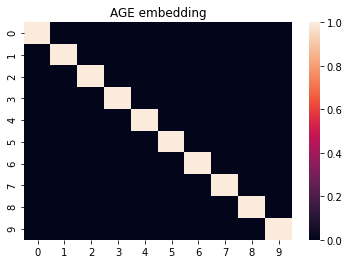

In [91]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

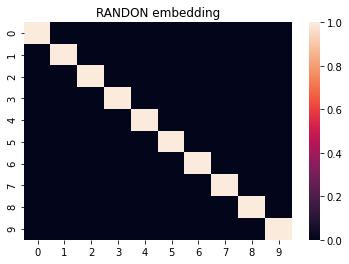

In [92]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

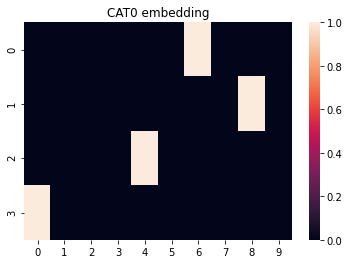

In [93]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

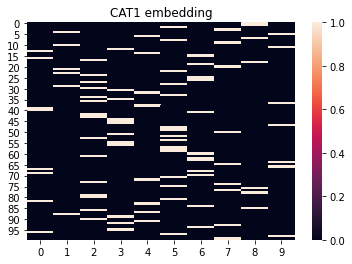

In [94]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

epoch1
====> Train NLL: 22912515.4543 	 Valid event loss: 11367201.2947 	 censoring loss : 0.0000 	 Improved: *
epoch2
====> Train NLL: 21771822.3734 	 Valid event loss: 10653704.8266 	 censoring loss : 0.0000 	 Improved: *
epoch3
====> Train NLL: 20078951.1902 	 Valid event loss: 9620332.0441 	 censoring loss : 0.0000 	 Improved: *
epoch4
====> Train NLL: 17634526.8157 	 Valid event loss: 8140983.3002 	 censoring loss : 0.0000 	 Improved: *
epoch5
====> Train NLL: 14193765.2598 	 Valid event loss: 6111260.2007 	 censoring loss : 0.0000 	 Improved: *
epoch6
====> Train NLL: 9763786.9157 	 Valid event loss: 3695888.7839 	 censoring loss : 0.0000 	 Improved: *
epoch7
====> Train NLL: 5093281.1499 	 Valid event loss: 1568463.2852 	 censoring loss : 0.0000 	 Improved: *
epoch8
====> Train NLL: 2102344.1074 	 Valid event loss: 783546.8018 	 censoring loss : 0.0000 	 Improved: *
epoch9
====> Train NLL: 1287853.4485 	 Valid event loss: 514240.3980 	 censoring loss : 0.0000 	 Improved: *
epoch

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


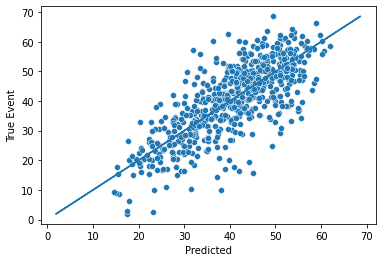

====> Train NLL: 911774.6184 	 Valid event loss: 404242.8543 	 censoring loss : 0.0000 	 Improved: *
epoch11
====> Train NLL: 803267.7625 	 Valid event loss: 385514.9256 	 censoring loss : 0.0000 	 Improved: *
epoch12
====> Train NLL: 763774.4335 	 Valid event loss: 372228.2031 	 censoring loss : 0.0000 	 Improved: *
epoch13
====> Train NLL: 723199.7451 	 Valid event loss: 353381.3778 	 censoring loss : 0.0000 	 Improved: *
epoch14
====> Train NLL: 727429.3788 	 Valid event loss: 347400.2055 	 censoring loss : 0.0000 	 Improved: *
epoch15
====> Train NLL: 697523.4443 	 Valid event loss: 343842.8587 	 censoring loss : 0.0000 	 Improved: *
epoch16
====> Train NLL: 700168.8689 	 Valid event loss: 338181.0290 	 censoring loss : 0.0000 	 Improved: *
epoch17
====> Train NLL: 675248.4529 	 Valid event loss: 327295.2378 	 censoring loss : 0.0000 	 Improved: *
epoch18
====> Train NLL: 682968.6622 	 Valid event loss: 328511.9495 	 censoring loss : 0.0000 	 Improved:  
epoch19
====> Train NLL: 65

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


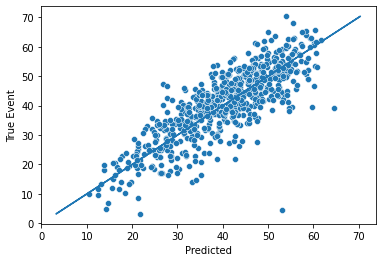

====> Train NLL: 660852.9042 	 Valid event loss: 323278.5251 	 censoring loss : 0.0000 	 Improved: *
epoch21
====> Train NLL: 647775.9555 	 Valid event loss: 314772.4879 	 censoring loss : 0.0000 	 Improved: *
epoch22
====> Train NLL: 641037.6212 	 Valid event loss: 321494.8267 	 censoring loss : 0.0000 	 Improved:  
epoch23
====> Train NLL: 635475.3392 	 Valid event loss: 323786.1396 	 censoring loss : 0.0000 	 Improved:  
epoch24
====> Train NLL: 628591.7291 	 Valid event loss: 311616.9498 	 censoring loss : 0.0000 	 Improved: *
epoch25
====> Train NLL: 632559.8736 	 Valid event loss: 310193.3216 	 censoring loss : 0.0000 	 Improved: *
epoch26
====> Train NLL: 622581.4535 	 Valid event loss: 306393.0643 	 censoring loss : 0.0000 	 Improved: *
epoch27
====> Train NLL: 619377.6959 	 Valid event loss: 302729.6564 	 censoring loss : 0.0000 	 Improved: *
epoch28
====> Train NLL: 618706.4384 	 Valid event loss: 308708.2020 	 censoring loss : 0.0000 	 Improved:  
epoch29
====> Train NLL: 61

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


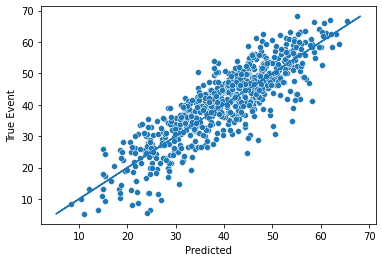

====> Train NLL: 607841.1135 	 Valid event loss: 293331.2685 	 censoring loss : 0.0000 	 Improved: *
epoch31
====> Train NLL: 597136.1559 	 Valid event loss: 291354.8823 	 censoring loss : 0.0000 	 Improved: *
epoch32
====> Train NLL: 599093.2800 	 Valid event loss: 298116.4751 	 censoring loss : 0.0000 	 Improved:  
epoch33
====> Train NLL: 597597.4540 	 Valid event loss: 294698.3200 	 censoring loss : 0.0000 	 Improved:  
epoch34
====> Train NLL: 588754.4181 	 Valid event loss: 291565.7086 	 censoring loss : 0.0000 	 Improved:  
epoch35
====> Train NLL: 597920.7412 	 Valid event loss: 289295.6089 	 censoring loss : 0.0000 	 Improved: *
epoch36
====> Train NLL: 583446.3178 	 Valid event loss: 292438.3669 	 censoring loss : 0.0000 	 Improved:  
epoch37
====> Train NLL: 581712.0792 	 Valid event loss: 290200.9213 	 censoring loss : 0.0000 	 Improved:  
epoch38
====> Train NLL: 577681.0478 	 Valid event loss: 289458.5395 	 censoring loss : 0.0000 	 Improved:  
epoch39
====> Train NLL: 58

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


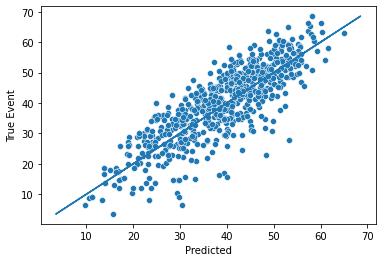

====> Train NLL: 578287.0052 	 Valid event loss: 286555.1574 	 censoring loss : 0.0000 	 Improved:  
epoch41
====> Train NLL: 568583.3018 	 Valid event loss: 279690.6690 	 censoring loss : 0.0000 	 Improved: *
epoch42
====> Train NLL: 572326.1914 	 Valid event loss: 276627.4287 	 censoring loss : 0.0000 	 Improved: *
epoch43
====> Train NLL: 576875.7136 	 Valid event loss: 285791.8952 	 censoring loss : 0.0000 	 Improved:  
epoch44
====> Train NLL: 573864.3942 	 Valid event loss: 281944.8133 	 censoring loss : 0.0000 	 Improved:  
epoch45
====> Train NLL: 569153.8661 	 Valid event loss: 276620.7986 	 censoring loss : 0.0000 	 Improved: *
epoch46
====> Train NLL: 559528.2362 	 Valid event loss: 282437.5682 	 censoring loss : 0.0000 	 Improved:  
epoch47
====> Train NLL: 562671.3305 	 Valid event loss: 276622.0024 	 censoring loss : 0.0000 	 Improved:  
epoch48
====> Train NLL: 562112.0583 	 Valid event loss: 278481.2551 	 censoring loss : 0.0000 	 Improved:  
epoch49
====> Train NLL: 55

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


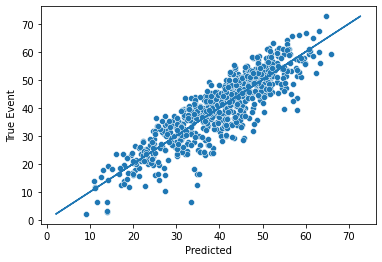

====> Train NLL: 555836.1063 	 Valid event loss: 273787.7248 	 censoring loss : 0.0000 	 Improved:  
epoch51
====> Train NLL: 553492.8594 	 Valid event loss: 280135.2059 	 censoring loss : 0.0000 	 Improved:  
epoch52
====> Train NLL: 552433.6008 	 Valid event loss: 272341.7755 	 censoring loss : 0.0000 	 Improved: *
epoch53
====> Train NLL: 552185.1864 	 Valid event loss: 266122.1913 	 censoring loss : 0.0000 	 Improved: *
epoch54
====> Train NLL: 550614.5337 	 Valid event loss: 271277.7356 	 censoring loss : 0.0000 	 Improved:  
epoch55
====> Train NLL: 544108.0005 	 Valid event loss: 270387.9999 	 censoring loss : 0.0000 	 Improved:  
epoch56
====> Train NLL: 546938.5987 	 Valid event loss: 265594.0436 	 censoring loss : 0.0000 	 Improved: *
epoch57
====> Train NLL: 542604.3611 	 Valid event loss: 270602.7454 	 censoring loss : 0.0000 	 Improved:  
epoch58
====> Train NLL: 544460.8643 	 Valid event loss: 266862.9485 	 censoring loss : 0.0000 	 Improved:  
epoch59
====> Train NLL: 54

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


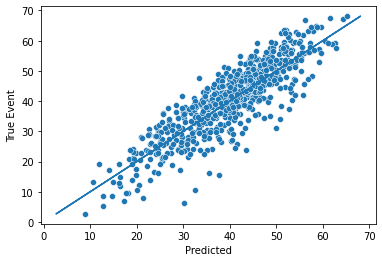

====> Train NLL: 544252.9356 	 Valid event loss: 263706.4961 	 censoring loss : 0.0000 	 Improved: *
epoch61
====> Train NLL: 537927.7684 	 Valid event loss: 265494.0439 	 censoring loss : 0.0000 	 Improved:  
epoch62
====> Train NLL: 532359.1631 	 Valid event loss: 268440.4562 	 censoring loss : 0.0000 	 Improved:  
epoch63
====> Train NLL: 536219.7969 	 Valid event loss: 265168.5226 	 censoring loss : 0.0000 	 Improved:  
epoch64
====> Train NLL: 539364.3909 	 Valid event loss: 268497.2945 	 censoring loss : 0.0000 	 Improved:  
epoch65
====> Train NLL: 531195.5037 	 Valid event loss: 263747.8387 	 censoring loss : 0.0000 	 Improved:  
epoch66
====> Train NLL: 536223.9115 	 Valid event loss: 261867.3595 	 censoring loss : 0.0000 	 Improved: *
epoch67
====> Train NLL: 531062.7777 	 Valid event loss: 264668.1060 	 censoring loss : 0.0000 	 Improved:  
epoch68
====> Train NLL: 526886.8607 	 Valid event loss: 263242.3515 	 censoring loss : 0.0000 	 Improved:  
epoch69
====> Train NLL: 52

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


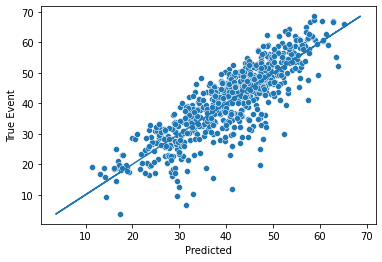

====> Train NLL: 525310.5301 	 Valid event loss: 260906.7555 	 censoring loss : 0.0000 	 Improved: *
epoch71
====> Train NLL: 527239.3983 	 Valid event loss: 262722.3457 	 censoring loss : 0.0000 	 Improved:  
epoch72
====> Train NLL: 523060.4336 	 Valid event loss: 262033.6685 	 censoring loss : 0.0000 	 Improved:  
epoch73
====> Train NLL: 523894.7764 	 Valid event loss: 258925.2197 	 censoring loss : 0.0000 	 Improved: *
epoch74
====> Train NLL: 521159.4738 	 Valid event loss: 262099.2347 	 censoring loss : 0.0000 	 Improved:  
epoch75
====> Train NLL: 518979.0633 	 Valid event loss: 262163.0093 	 censoring loss : 0.0000 	 Improved:  
epoch76
====> Train NLL: 526706.9358 	 Valid event loss: 256689.2036 	 censoring loss : 0.0000 	 Improved: *
epoch77
====> Train NLL: 517996.1548 	 Valid event loss: 256979.0043 	 censoring loss : 0.0000 	 Improved:  
epoch78
====> Train NLL: 521000.5955 	 Valid event loss: 255932.0198 	 censoring loss : 0.0000 	 Improved: *
epoch79
====> Train NLL: 51

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


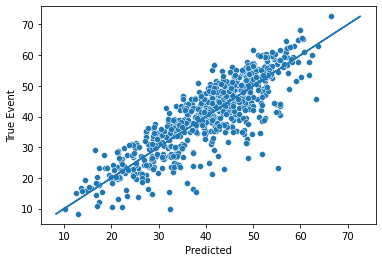

====> Train NLL: 520499.8132 	 Valid event loss: 257621.9775 	 censoring loss : 0.0000 	 Improved:  
epoch81
====> Train NLL: 516664.6516 	 Valid event loss: 258249.9409 	 censoring loss : 0.0000 	 Improved:  
epoch82
====> Train NLL: 514696.0383 	 Valid event loss: 257871.0976 	 censoring loss : 0.0000 	 Improved:  
epoch83
====> Train NLL: 512185.1671 	 Valid event loss: 256744.6158 	 censoring loss : 0.0000 	 Improved:  
epoch84
====> Train NLL: 513973.5755 	 Valid event loss: 255971.7846 	 censoring loss : 0.0000 	 Improved:  
epoch85
====> Train NLL: 513379.0388 	 Valid event loss: 255941.3621 	 censoring loss : 0.0000 	 Improved:  
epoch86
====> Train NLL: 512896.8964 	 Valid event loss: 254203.7125 	 censoring loss : 0.0000 	 Improved: *
epoch87
====> Train NLL: 512605.7335 	 Valid event loss: 252233.8094 	 censoring loss : 0.0000 	 Improved: *
epoch88
====> Train NLL: 512342.3517 	 Valid event loss: 254991.8211 	 censoring loss : 0.0000 	 Improved:  
epoch89
====> Train NLL: 51

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


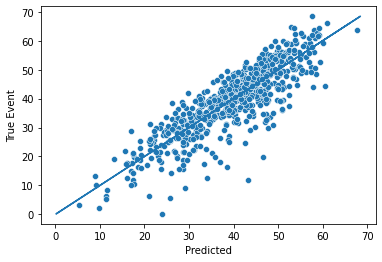

====> Train NLL: 515208.1733 	 Valid event loss: 251058.7459 	 censoring loss : 0.0000 	 Improved: *
epoch91
====> Train NLL: 511917.3932 	 Valid event loss: 253859.5659 	 censoring loss : 0.0000 	 Improved:  
epoch92
====> Train NLL: 509133.9498 	 Valid event loss: 252467.9956 	 censoring loss : 0.0000 	 Improved:  
epoch93
====> Train NLL: 510346.7502 	 Valid event loss: 253899.4685 	 censoring loss : 0.0000 	 Improved:  
epoch94
====> Train NLL: 505873.9232 	 Valid event loss: 249554.9985 	 censoring loss : 0.0000 	 Improved: *
epoch95
====> Train NLL: 506187.1645 	 Valid event loss: 251627.2313 	 censoring loss : 0.0000 	 Improved:  
epoch96
====> Train NLL: 505020.0888 	 Valid event loss: 251048.0836 	 censoring loss : 0.0000 	 Improved:  
epoch97
====> Train NLL: 504057.5661 	 Valid event loss: 251607.3205 	 censoring loss : 0.0000 	 Improved:  
epoch98
====> Train NLL: 503918.2460 	 Valid event loss: 253498.4850 	 censoring loss : 0.0000 	 Improved:  
epoch99
====> Train NLL: 50

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


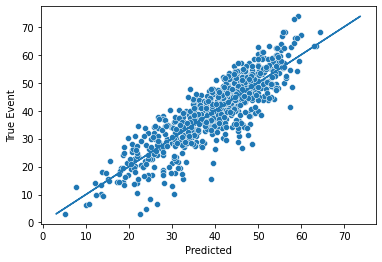

====> Train NLL: 506995.3533 	 Valid event loss: 253364.7630 	 censoring loss : 0.0000 	 Improved:  
epoch101
====> Train NLL: 501999.8617 	 Valid event loss: 250834.5688 	 censoring loss : 0.0000 	 Improved:  
epoch102
====> Train NLL: 501894.2029 	 Valid event loss: 248990.5734 	 censoring loss : 0.0000 	 Improved: *
epoch103
====> Train NLL: 503674.0668 	 Valid event loss: 248417.0635 	 censoring loss : 0.0000 	 Improved: *
epoch104
====> Train NLL: 504691.1959 	 Valid event loss: 251157.1230 	 censoring loss : 0.0000 	 Improved:  
epoch105
====> Train NLL: 505207.1948 	 Valid event loss: 252773.8533 	 censoring loss : 0.0000 	 Improved:  
epoch106
====> Train NLL: 500765.0271 	 Valid event loss: 251104.2597 	 censoring loss : 0.0000 	 Improved:  
epoch107
====> Train NLL: 505311.0203 	 Valid event loss: 251508.2042 	 censoring loss : 0.0000 	 Improved:  
epoch108
====> Train NLL: 500905.1696 	 Valid event loss: 248427.5863 	 censoring loss : 0.0000 	 Improved:  
epoch109
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


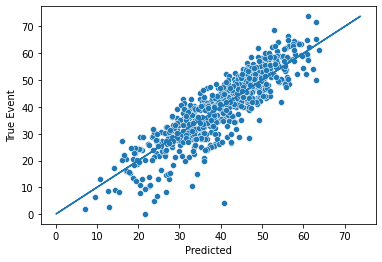

====> Train NLL: 499253.5483 	 Valid event loss: 249984.7764 	 censoring loss : 0.0000 	 Improved:  
epoch111
====> Train NLL: 495915.9613 	 Valid event loss: 248885.7058 	 censoring loss : 0.0000 	 Improved:  
epoch112
====> Train NLL: 501250.0396 	 Valid event loss: 251611.2459 	 censoring loss : 0.0000 	 Improved:  
epoch113
====> Train NLL: 500004.2523 	 Valid event loss: 251659.2958 	 censoring loss : 0.0000 	 Improved:  
epoch114
====> Train NLL: 502764.8102 	 Valid event loss: 252674.0661 	 censoring loss : 0.0000 	 Improved:  
epoch115
====> Train NLL: 499797.3651 	 Valid event loss: 248268.4496 	 censoring loss : 0.0000 	 Improved: *
epoch116
====> Train NLL: 497465.1630 	 Valid event loss: 248656.7195 	 censoring loss : 0.0000 	 Improved:  
epoch117
====> Train NLL: 498362.4805 	 Valid event loss: 245835.6333 	 censoring loss : 0.0000 	 Improved: *
epoch118
====> Train NLL: 497862.1956 	 Valid event loss: 249076.0073 	 censoring loss : 0.0000 	 Improved:  
epoch119
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


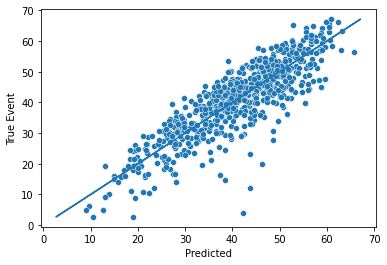

====> Train NLL: 494941.4482 	 Valid event loss: 248146.5610 	 censoring loss : 0.0000 	 Improved:  
epoch121
====> Train NLL: 494117.5723 	 Valid event loss: 246562.2266 	 censoring loss : 0.0000 	 Improved:  
epoch122
====> Train NLL: 492687.0683 	 Valid event loss: 247966.4523 	 censoring loss : 0.0000 	 Improved:  
epoch123
====> Train NLL: 496655.7860 	 Valid event loss: 247689.8383 	 censoring loss : 0.0000 	 Improved:  
epoch124
====> Train NLL: 492334.8166 	 Valid event loss: 247931.2823 	 censoring loss : 0.0000 	 Improved:  
epoch125
====> Train NLL: 497104.4249 	 Valid event loss: 247449.9995 	 censoring loss : 0.0000 	 Improved:  
epoch126
====> Train NLL: 492381.3300 	 Valid event loss: 248597.1963 	 censoring loss : 0.0000 	 Improved:  
epoch127
====> Train NLL: 493008.9819 	 Valid event loss: 247514.8417 	 censoring loss : 0.0000 	 Improved:  
epoch128
====> Train NLL: 497979.3778 	 Valid event loss: 249035.7344 	 censoring loss : 0.0000 	 Improved:  
epoch129
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


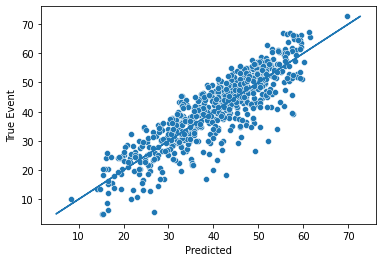

====> Train NLL: 492891.9363 	 Valid event loss: 246240.7613 	 censoring loss : 0.0000 	 Improved:  
epoch131
====> Train NLL: 494853.3360 	 Valid event loss: 246155.5067 	 censoring loss : 0.0000 	 Improved:  
epoch132
====> Train NLL: 494427.9488 	 Valid event loss: 245802.6292 	 censoring loss : 0.0000 	 Improved: *
epoch133
====> Train NLL: 488252.7695 	 Valid event loss: 245803.4646 	 censoring loss : 0.0000 	 Improved:  
epoch134
====> Train NLL: 492164.2980 	 Valid event loss: 244854.9602 	 censoring loss : 0.0000 	 Improved: *
epoch135
====> Train NLL: 490122.8600 	 Valid event loss: 244083.9277 	 censoring loss : 0.0000 	 Improved: *
epoch136
====> Train NLL: 489860.1065 	 Valid event loss: 246349.5211 	 censoring loss : 0.0000 	 Improved:  
epoch137
====> Train NLL: 491392.6625 	 Valid event loss: 245250.6745 	 censoring loss : 0.0000 	 Improved:  
epoch138
====> Train NLL: 490148.2149 	 Valid event loss: 245794.6946 	 censoring loss : 0.0000 	 Improved:  
epoch139
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


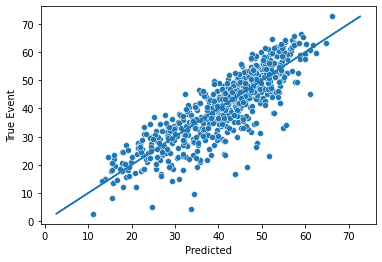

====> Train NLL: 489204.2262 	 Valid event loss: 246058.4063 	 censoring loss : 0.0000 	 Improved:  
epoch141
====> Train NLL: 490368.9849 	 Valid event loss: 247709.0817 	 censoring loss : 0.0000 	 Improved:  
epoch142
====> Train NLL: 490439.9681 	 Valid event loss: 245744.4053 	 censoring loss : 0.0000 	 Improved:  
epoch143
====> Train NLL: 488168.7791 	 Valid event loss: 248536.8156 	 censoring loss : 0.0000 	 Improved:  
epoch144
====> Train NLL: 491578.2823 	 Valid event loss: 251278.3692 	 censoring loss : 0.0000 	 Improved:  
epoch145
====> Train NLL: 496982.0182 	 Valid event loss: 245057.7599 	 censoring loss : 0.0000 	 Improved:  
epoch146
====> Train NLL: 490865.1294 	 Valid event loss: 245926.4208 	 censoring loss : 0.0000 	 Improved:  
epoch147
====> Train NLL: 488906.5854 	 Valid event loss: 245906.3464 	 censoring loss : 0.0000 	 Improved:  
epoch148
====> Train NLL: 487198.7869 	 Valid event loss: 244914.4765 	 censoring loss : 0.0000 	 Improved:  
epoch149
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


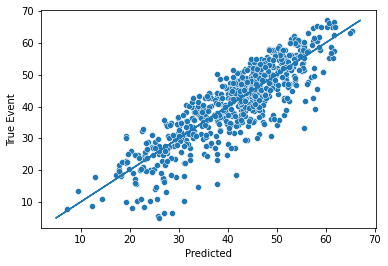

====> Train NLL: 490708.5956 	 Valid event loss: 247539.5050 	 censoring loss : 0.0000 	 Improved:  
epoch151
====> Train NLL: 490518.1343 	 Valid event loss: 246732.2396 	 censoring loss : 0.0000 	 Improved:  
epoch152
====> Train NLL: 489165.7034 	 Valid event loss: 246518.3063 	 censoring loss : 0.0000 	 Improved:  
epoch153
====> Train NLL: 486588.6401 	 Valid event loss: 247291.0029 	 censoring loss : 0.0000 	 Improved:  
epoch154
====> Train NLL: 487329.9794 	 Valid event loss: 245940.7936 	 censoring loss : 0.0000 	 Improved:  
epoch155
====> Train NLL: 487365.9487 	 Valid event loss: 243662.4405 	 censoring loss : 0.0000 	 Improved: *
epoch156
====> Train NLL: 486491.7775 	 Valid event loss: 248274.9974 	 censoring loss : 0.0000 	 Improved:  
epoch157
====> Train NLL: 485924.8480 	 Valid event loss: 245899.6739 	 censoring loss : 0.0000 	 Improved:  
epoch158
====> Train NLL: 486893.0268 	 Valid event loss: 244990.5593 	 censoring loss : 0.0000 	 Improved:  
epoch159
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


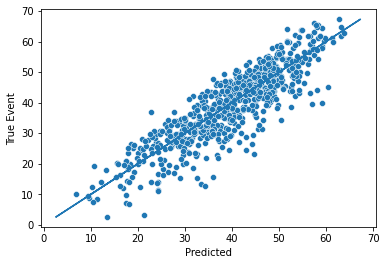

====> Train NLL: 484841.6141 	 Valid event loss: 247408.8244 	 censoring loss : 0.0000 	 Improved:  
epoch161
====> Train NLL: 485849.7819 	 Valid event loss: 246271.4842 	 censoring loss : 0.0000 	 Improved:  
epoch162
====> Train NLL: 486682.8975 	 Valid event loss: 247490.7833 	 censoring loss : 0.0000 	 Improved:  
epoch163
====> Train NLL: 486920.6043 	 Valid event loss: 244594.0224 	 censoring loss : 0.0000 	 Improved:  
epoch164
====> Train NLL: 483785.7981 	 Valid event loss: 246318.1343 	 censoring loss : 0.0000 	 Improved:  
epoch165
====> Train NLL: 487532.2240 	 Valid event loss: 244619.8008 	 censoring loss : 0.0000 	 Improved:  
epoch166
====> Train NLL: 486546.0054 	 Valid event loss: 246079.5451 	 censoring loss : 0.0000 	 Improved:  
epoch167
====> Train NLL: 485338.4778 	 Valid event loss: 243941.6926 	 censoring loss : 0.0000 	 Improved:  
epoch168
====> Train NLL: 482740.5246 	 Valid event loss: 246445.8315 	 censoring loss : 0.0000 	 Improved:  
epoch169
====> Trai

/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


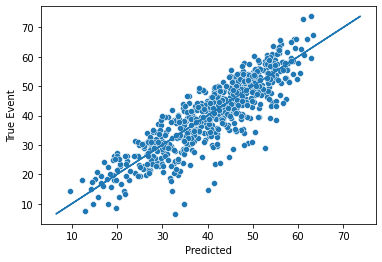

====> Train NLL: 484515.4578 	 Valid event loss: 247693.3046 	 censoring loss : 0.0000 	 Improved:  
epoch171
====> Train NLL: 484254.3334 	 Valid event loss: 247098.5205 	 censoring loss : 0.0000 	 Improved:  
epoch172
====> Train NLL: 482315.6876 	 Valid event loss: 247328.3024 	 censoring loss : 0.0000 	 Improved:  
epoch173
====> Train NLL: 482559.1360 	 Valid event loss: 246800.1349 	 censoring loss : 0.0000 	 Improved:  
epoch174
====> Train NLL: 483467.5584 	 Valid event loss: 246110.6896 	 censoring loss : 0.0000 	 Improved:  
epoch175
====> Train NLL: 484942.4001 	 Valid event loss: 245242.9424 	 censoring loss : 0.0000 	 Improved:  
Model stopped due to early stopping


In [ ]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_e_loss = 0
    valid_c_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    embedding.train()
#     attention.train()
    decoder.train()
    for i, (x, y, e) in enumerate(pair1):
        
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat-y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
        loss = closs + eloss
    
        
#         y_loglikeli = -((p_raw*torch.tensor(y_cat)).sum(axis=1)+1e-4).log().mean()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(embedding.parameters(), 1e-1)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1e-1)

        train_loss += loss.item()
        
        opt_emb.step()
#         opt_att.step()
        opt_dec.step()  
        
#     train_loss = train_loss/(i+1)     

    
    embedding.eval()
#     attention.eval()
    decoder.eval()
    
    valid_e_loss = 0
    valid_c_loss = 0
    for i, (x, y, e) in enumerate(v_pair1):
        x= x.to(device).float()
        y = y.to(device).float()
        e = e.to(device)
        
        x_emb = embedding(x.float())
        z = attention(x_emb)
        t_hat = decoder(z)
        hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
        closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
        eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()
#         valid_loss_ = eloss.item()

        valid_e_loss += eloss.item()
        valid_c_loss += closs.item()



#     valid_e_loss = valid_e_loss/(i+1)
#     valid_c_loss = valid_c_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_e_loss)
    
    save_model = 0
    if (best_valid_loss > valid_e_loss):
        save_model += 1
        
    if epoch % 10 == 0:
        subj = np.random.choice(len(e))
        plt.figure()
        
        sns.scatterplot(t_hat[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.plot(y[e==1].cpu().detach().numpy().squeeze(), y[e==1].cpu().detach().numpy().squeeze())
        plt.xlabel('Predicted')
        plt.ylabel('True Event')
        
        
#         plt.axvline(y[subj],linestyle='--',color=emp_color,label='observed t_k')

# #         sns.scatterplot(tt, p_raw[subj,:].detach().numpy(), label='Estimated', color=pred_color)
#         true_T = single_patient_true_dist_cox_gompertz((x[subj,:]*std)+mean)['T']
#         sns.distplot(true_T, rug=True, hist=False, label="Empirical", color=emp_color)
#         plt.xticks(np.arange(0, 100, step=5), np.arange(0, 100, step=5))  # Set label locations.
#         plt.title(r'$\delta$='+str(e[subj].item()))

        plt.show()
    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_e_loss
        torch.save(embedding.state_dict(), emb_path)
#         torch.save(attention.state_dict(), att_path)
        torch.save(decoder.state_dict(), dec_path)

        improved_str = "*"
    print('====> Train NLL: {:.4f} \t Valid event loss: {:.4f} \t censoring loss : {:.4f} \t Improved: {}'.format(train_loss, valid_e_loss,valid_c_loss,improved_str))

    if epoch - best_epoch >=20:
        print('Model stopped due to early stopping')
        break

In [ ]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()


In [47]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

for name, param in embedding.named_parameters():
    if param.requires_grad:
        print(name, param.data)

x_emb_landmarks.AGE tensor([[-0.7719,  1.3817,  1.5944,  1.7195,  1.3515,  1.4887,  1.7987,  1.5827,
          1.8326, -1.0740],
        [-0.5623,  1.0322,  0.7005,  0.8542,  0.5251,  0.7584,  0.9262,  0.7819,
          0.9323, -0.2237],
        [-0.3927,  0.5364,  0.6739,  0.5602,  0.4056,  0.5654,  0.7162,  0.5689,
          0.6501, -0.2191],
        [-0.2603,  0.5468,  0.3968,  0.5537,  0.2641,  0.4152,  0.5342,  0.4366,
          0.5593, -0.1513],
        [-0.2151,  0.3958,  0.3293,  0.3383,  0.3267,  0.2782,  0.4136,  0.3730,
          0.3671, -0.1143],
        [-0.1408,  0.2444,  0.1890,  0.2163,  0.0798,  0.3659,  0.2002,  0.2228,
          0.2632, -0.0560],
        [-0.0656,  0.1338,  0.1026,  0.1505,  0.0894,  0.0573,  0.3209,  0.0394,
          0.1160, -0.0282],
        [ 0.1117, -0.1110, -0.0797, -0.0682, -0.1316, -0.1041, -0.1274,  0.1129,
         -0.1293,  0.0670],
        [ 0.2632, -0.3174, -0.2746, -0.2474, -0.1843, -0.3031, -0.2811, -0.2767,
         -0.1001,  0.0073],

Text(0.5, 1.0, 'AGE embedding')

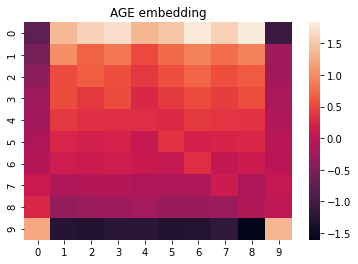

In [48]:
ax = sns.heatmap(embedding.x_emb_landmarks['AGE'].detach().cpu().numpy())
plt.title('AGE embedding')

Text(0.5, 1.0, 'RANDON embedding')

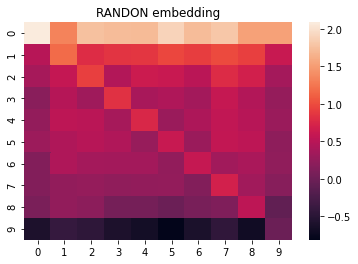

In [49]:
ax = sns.heatmap(embedding.x_emb_landmarks['RANDON'].detach().cpu().numpy())
plt.title('RANDON embedding')

Text(0.5, 1.0, 'CAT0 embedding')

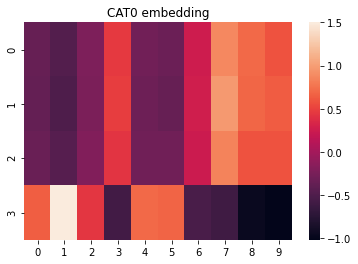

In [50]:
ax = sns.heatmap(embedding.x_emb_levels['cat0'].detach().cpu().numpy())
plt.title('CAT0 embedding')

Text(0.5, 1.0, 'CAT1 embedding')

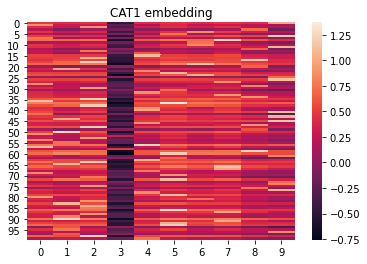

In [51]:
ax = sns.heatmap(embedding.x_emb_levels['cat1'].detach().cpu().numpy())
plt.title('CAT1 embedding')

In [52]:
embedding.load_state_dict(torch.load(emb_path))
decoder.load_state_dict(torch.load(dec_path))

embedding.eval()
decoder.eval()
valid_e_loss = valid_c_loss= 0
valid_pred_t = []
valid_t = []
valid_e = []
for i, (x, y, e) in enumerate(v_pair1):
    x= x.to(device).float()
    y = y.to(device).float()
    e = e.to(device)        
    x_emb = embedding(x.float())
    z = attention(x_emb)
    t_hat = decoder(z)
    hinge_loss,_ = torch.min(torch.cat([t_hat - y.unsqueeze(1), torch.zeros_like(t_hat).to(device)], dim=1), 1, keepdim=True)
    closs = ((1-e)*torch.abs(hinge_loss.squeeze())).sum()
    eloss = (e*torch.pow((y-t_hat.squeeze()),2)).sum()

    valid_e_loss += eloss.item()

    valid_c_loss += closs.item()
    
    valid_pred_t.append(t_hat.squeeze())
    valid_t.append(y.squeeze())
    valid_e.append(e.squeeze())

print(valid_e_loss)


255835.2815718758


/data/zidi/ACSurv/workspace/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'True Event')

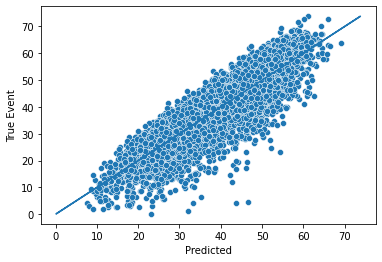

In [53]:
valid_e = torch.cat(valid_e)
valid_t = torch.cat(valid_t)
valid_pred_t = torch.cat(valid_pred_t)


subj = np.random.choice(len(valid_e))
plt.figure()

sns.scatterplot(valid_pred_t[valid_e==1].cpu().detach().numpy().squeeze(), valid_t[valid_e==1].cpu())
plt.plot(valid_t[valid_e==1].cpu(), valid_t[valid_e==1].cpu())
plt.xlabel('Predicted')
plt.ylabel('True Event')
